<a href="https://colab.research.google.com/github/wenjunsun/personal-machine-learning-projects/blob/master/deep-learning/telling_bird_from_plane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will build a neural network to recognize if a image contains a bird or a plane by using the `CIFAR-10` dataset.

# load and look at data

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [3]:
cifar10 = datasets.CIFAR10('./', train = True, download = True)

Extracting ./cifar-10-python.tar.gz to ./


In [4]:
cifar10_val = datasets.CIFAR10('./', train = False, download=True)

Files already downloaded and verified


In [5]:
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

In [6]:
cifar10_val

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./
    Split: Test

all `pytorch` `dataset` objects have to implement 2 methods:
- one method is to return the length of the dataset.
- another method is to __getitem__ method.

so we can call `len (dataset)` and `dataset[index]`

In [7]:
len(cifar10)

50000

In [8]:
cifar10[1]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F1CF26E3EF0>, 9)

In [9]:
# mapping from label (a number) to the string that represents
# that image.
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

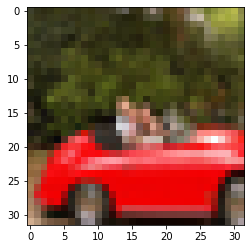

In [10]:
plt.imshow(cifar10[99][0])

In [11]:
cifar10[99][1]

1

In [12]:
class_names[cifar10[99][1]]

'automobile'

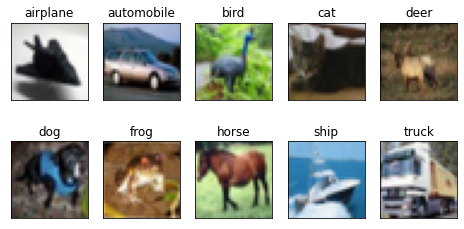

In [13]:
fig = plt.figure(figsize=(8,4))
num_classes = 10
for i in range(num_classes):
  for j in range(len(cifar10)):
    if cifar10[j][1] == i:
      # 2, 5 specifies we want 2 by 5 subplots, 1 + i
      # specifies which plot this specific image occupies (1 - 10)
      # xticks = [] and yticks = [] means we don't want to show
      # numbers on the x and y axis.
      ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
      ax.set_title(class_names[i])
      img = cifar10[j][0]
      plt.imshow(img)
      break
plt.show()

# make image a tensor!

In [14]:
# torchvision has a function that takes an PIL image
# and transform into a tensor.
to_tensor_fn = torchvision.transforms.ToTensor()

In [15]:
image_tensor = to_tensor_fn(cifar10[99][0])

In [16]:
image_tensor

tensor([[[0.2431, 0.1961, 0.1804,  ..., 0.6549, 0.7176, 0.5373],
         [0.2471, 0.2157, 0.2039,  ..., 0.6392, 0.6706, 0.5686],
         [0.2275, 0.2510, 0.2196,  ..., 0.6000, 0.5882, 0.4824],
         ...,
         [0.6745, 0.5608, 0.5098,  ..., 0.3686, 0.5529, 0.5451],
         [0.7176, 0.5882, 0.3137,  ..., 0.3176, 0.5294, 0.5608],
         [0.8196, 0.7137, 0.5451,  ..., 0.2314, 0.5098, 0.6627]],

        [[0.2510, 0.1961, 0.1725,  ..., 0.6745, 0.7216, 0.5333],
         [0.2549, 0.2078, 0.1961,  ..., 0.6627, 0.6824, 0.5725],
         [0.2431, 0.2588, 0.2353,  ..., 0.6078, 0.6039, 0.5020],
         ...,
         [0.5294, 0.4314, 0.2196,  ..., 0.2941, 0.4235, 0.4118],
         [0.5725, 0.4627, 0.2510,  ..., 0.2824, 0.4627, 0.4902],
         [0.6824, 0.5922, 0.4275,  ..., 0.2118, 0.4667, 0.6118]],

        [[0.1725, 0.1020, 0.0745,  ..., 0.2706, 0.2980, 0.2824],
         [0.1451, 0.1020, 0.1059,  ..., 0.2392, 0.2941, 0.3020],
         [0.1412, 0.1451, 0.1451,  ..., 0.2431, 0.2510, 0.

In [17]:
image_tensor.max()

tensor(1.)

In [18]:
image_tensor.min()

tensor(0.)

In [19]:
image_tensor.shape

torch.Size([3, 32, 32])

when we transform the image pixels into a tensor, we automatically get floating point numbers from `0` to `1`. Remember in the original `PIL` image representation, each pixel number should be from `0` to `255`.

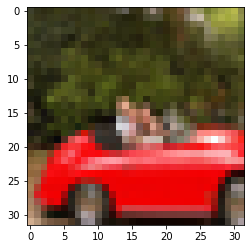

In [20]:
# see we can still plot this tensor: imshow expects
# W X H X C. our tensor is in C X W X H
plt.imshow(image_tensor.permute(1, 2, 0))

# normalizing image

In [21]:
# luckily, when we load the dataset we can specify the transform function
# already, so we don't have to transform the dataset ourselves after
# loading in the raw data.
tensors_cifar10 = datasets.CIFAR10('./', train=True, download=False,
                                  transform=transforms.ToTensor())

In [22]:
type(tensors_cifar10[1][0]), tensors_cifar10[1][0].shape, tensors_cifar10[1][0].dtype

(torch.Tensor, torch.Size([3, 32, 32]), torch.float32)

To let the `torchvision` package do the normalization, we need to pass in the mean and standard deviation of each channel across all images. So we need to calculate those `2` values ourselves and pass that into the transform function.

In [23]:
# collect all the image tensors together along the last
# dimension, so as to help aggregate function later:
# 3 x 32 x 32 x 50000.
image_tensors = torch.stack([image for image, label in tensors_cifar10], dim = -1)

In [24]:
image_tensors.shape

torch.Size([3, 32, 32, 50000])

In [25]:
# this exactly gives us all the pixel values of each channel
# across all images.
# we need to do mean and std on this tensor for each
# of the 3 dimensions.
image_tensors.view(3, -1).shape

torch.Size([3, 51200000])

In [26]:
torch.mean(image_tensors.view(3, -1), dim = 1)

tensor([0.4914, 0.4822, 0.4465])

In [27]:
torch.std(image_tensors.view(3, -1), dim = 1)

tensor([0.2470, 0.2435, 0.2616])

these are the numbers we can plug into our `transforms.Normalize()` function!

In [28]:
cifar10 = datasets.CIFAR10('./', train=True, download=False,
                           transform = transforms.Compose(
                               [transforms.ToTensor(),
                                transforms.Normalize(mean = (0.4914, 0.4822, 0.4465),
                                                     std = (0.2470, 0.2435, 0.2616))]
                          ))

In [29]:
# load validation set data with the same normalization constants
# note that when we calculate these constants we only looked
# at training set.
cifar10_val = datasets.CIFAR10('./', train=False, download=False,
                               transform = transforms.Compose(
                                   [transforms.ToTensor(),
                                    transforms.Normalize(mean = (0.4914, 0.4822, 0.4465),
                                                         std = (0.2470, 0.2435, 0.2616))]
                              ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


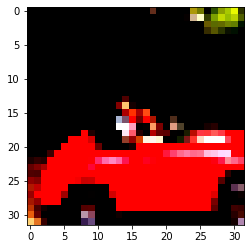

In [30]:
# normalized image.
plt.imshow(cifar10[99][0].permute(1, 2, 0))

# Get our dataset of birds and planes

In [31]:
# label of plane = 0, label of birds = 2 in our original
# CIFAR dataset. We will only extract images with these
# 2 labels in both train and validation set.
class_names = ['plane', 'bird']

In [32]:
# we will map plane to 0, and bird to 1 in our dataset.
label_map = {0 : 0, 2: 1}

In [33]:
cifar_birds_and_planes = [(img, label_map[label]) for img, label in cifar10 if label in {0, 2}]
cifar_val_birds_and_planes = [(img, label_map[label]) for img, label in cifar10_val if label in {0, 2}]

We could build a `Dataset` object, but we choose to just use the `list` here to store the data, because it satisfies having `__len__()` and `__getitem__()`.

In [46]:
# size of birds and planes dataset
len(cifar_birds_and_planes)

10000

In [47]:
len(cifar_val_birds_and_planes)

2000

In [50]:
# number of birds images in training set
len([(image, label) for image, label in cifar_birds_and_planes if label == 1])

5000

In [51]:
# number of birds images in training set
len([(image, label) for image, label in cifar_val_birds_and_planes if label == 1])

1000

We can see that our dataset is balanced, there are the half images that are birds and half that are planes, which is good.

# build neural net architecture!

In [36]:
import torch.nn as nn
import torch.optim as optim

In [57]:
# 3 x 32 x 32 -> input vector has size of 3072.
torch.prod(torch.tensor(cifar_birds_and_planes[0][0].shape))

tensor(3072)

In [94]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim = 1)) # softmax as to produce probabilities over linear units, Log as to help with numerical stability.

In [89]:
softmax = nn.Softmax(dim = 1)

In [90]:
softmax(torch.tensor([[1.,2,3], 
                      [3.,4,5]]))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [92]:
torch.exp(torch.tensor([1. ,2, 3])) / torch.exp(torch.tensor([1. ,2, 3])).sum()

tensor([0.0900, 0.2447, 0.6652])

In [95]:
# but now our loss shouldn't be MSE loss, and we should
# use negative log likelihood loss, which is just the negative
# of the log, taking range from 0 to 1.

# nn.NLLLoss() takes in a (log) probability distribution vector, and the index
# of the one probability we want to compute.
loss_fn = nn.NLLLoss()

![](https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log.png)

Let's now pass one image of our dataset to the neural net. See if loss and everything works.

In [99]:
# view as to squash the 3 x 32 x 32 matrix into a 3072 vector
# unsqueeze as to add an extra dimension for the batch processing
# of the neural net.
batch = cifar_birds_and_planes[0][0].view(-1).unsqueeze(0)
label = cifar_birds_and_planes[0][1]

In [101]:
loss_fn(model(batch), torch.tensor([label]))

tensor(0.6264, grad_fn=<NllLossBackward>)

# train the damn thing!

In [103]:
lr = 1e-2

In [106]:
optimizer = optim.SGD(params = model.parameters(), lr = lr)

In [135]:
def training_loop(num_epochs, optimizer, model, loss_function, x_train, y_train,
                  x_validation, y_validation):
  for curr_epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    y_pred = model(x_train)
    train_loss = loss_function(y_pred, y_train)
    train_loss.backward()

    optimizer.step() # update parameters this optimizer owns via GD

    with torch.no_grad(): # to calculate validation loss we don't want to keep track of gradients!
      validate_loss = loss_function(model(x_validation), y_validation)

    if curr_epoch % 10 == 0:
      print(f'at epoch {curr_epoch} in the training, train loss is {train_loss}')
      print(f'at epoch {curr_epoch} in the training, validation loss is {validate_loss}')

In [118]:
x_train = torch.stack([img_and_label[0] for img_and_label in cifar_birds_and_planes])

In [119]:
x_train.shape

torch.Size([10000, 3, 32, 32])

In [120]:
# collapse 3 x 32 x 32 into 3072
x_train = x_train.view(10000, -1)

In [121]:
x_train.shape

torch.Size([10000, 3072])

In [131]:
y_train = torch.stack([torch.tensor(img_and_label[1]) for img_and_label in cifar_birds_and_planes])

In [125]:
y_train.shape

torch.Size([10000])

In [126]:
y_train.unsqueeze_(1)

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [1]])

In [127]:
y_train.shape

torch.Size([10000, 1])

In [128]:
x_val = torch.stack([img_and_label[0] for img_and_label in cifar_val_birds_and_planes])
x_val = x_val.view(2000, -1)

In [132]:
y_val = torch.stack([torch.tensor(img_and_label[1]) for img_and_label in cifar_val_birds_and_planes])

In [141]:
training_loop(100, optimizer, model, loss_fn, x_train, y_train, x_val, y_val)

at epoch 10 in the training, train loss is 0.4095042645931244
at epoch 10 in the training, validation loss is 0.43029797077178955
at epoch 20 in the training, train loss is 0.408574640750885
at epoch 20 in the training, validation loss is 0.4298960268497467
at epoch 30 in the training, train loss is 0.4076526165008545
at epoch 30 in the training, validation loss is 0.429503858089447
at epoch 40 in the training, train loss is 0.40673843026161194
at epoch 40 in the training, validation loss is 0.42912039160728455
at epoch 50 in the training, train loss is 0.4058341681957245
at epoch 50 in the training, validation loss is 0.4287464916706085
at epoch 60 in the training, train loss is 0.40493419766426086
at epoch 60 in the training, validation loss is 0.42838090658187866
at epoch 70 in the training, train loss is 0.4040410816669464
at epoch 70 in the training, validation loss is 0.42802396416664124
at epoch 80 in the training, train loss is 0.4031551480293274
at epoch 80 in the training, va

Now the training loop runs considerably longer than before because each time it is taking a gradient with respect to all `10000` images, which take a long time. Even running just 100 loops takes about 1 minute. (without GPU.) We can consider to do SGD, taking gradient just with respect to a single image at one time, to speed up the process.

We have ran about 700 training loops, let's now look at the accuracy.

In [154]:
with torch.no_grad():
  count = 0
  y_pred = model(x_val)
  label_pred = torch.argmax(y_pred, dim = 1)
  for i in range(len(y_pred)):
    if label_pred[i] == y_val[i]:
      count += 1
  print(f'Accuracy on validation set: {count / len(label_pred)}')

Accuracy on validation set: 0.807


Not shabby at all! Our vanilla neural net can now recognize birds from planes at a 80% accuracy! This is even without training a long time and without convolutions!

Let's run the training a bit more.

In [155]:
training_loop(250, optimizer, model, loss_fn, x_train, y_train, x_val, y_val)

at epoch 10 in the training, train loss is 0.40053343772888184
at epoch 10 in the training, validation loss is 0.42666858434677124
at epoch 20 in the training, train loss is 0.3996707499027252
at epoch 20 in the training, validation loss is 0.4263470768928528
at epoch 30 in the training, train loss is 0.3988129496574402
at epoch 30 in the training, validation loss is 0.42603135108947754
at epoch 40 in the training, train loss is 0.3979590833187103
at epoch 40 in the training, validation loss is 0.4257218539714813
at epoch 50 in the training, train loss is 0.39710959792137146
at epoch 50 in the training, validation loss is 0.4254171848297119
at epoch 60 in the training, train loss is 0.39626702666282654
at epoch 60 in the training, validation loss is 0.4251188635826111
at epoch 70 in the training, train loss is 0.3954259157180786
at epoch 70 in the training, validation loss is 0.4248256981372833
at epoch 80 in the training, train loss is 0.3945895731449127
at epoch 80 in the training, v

In [163]:
def get_accuracy():
  with torch.no_grad():
    count = 0
    y_pred = model(x_val)
    label_pred = torch.argmax(y_pred, dim = 1)
    for i in range(len(y_pred)):
      if label_pred[i] == y_val[i]:
        count += 1
    print(f'Accuracy on validation set is: {count / len(label_pred)}')

In [159]:
get_accuracy()

Accuracy on validation set: 0.813


In [160]:
training_loop(250, optimizer, model, loss_fn, x_train, y_train, x_val, y_val)

at epoch 10 in the training, train loss is 0.3800166845321655
at epoch 10 in the training, validation loss is 0.42001479864120483
at epoch 20 in the training, train loss is 0.3792267441749573
at epoch 20 in the training, validation loss is 0.41979366540908813
at epoch 30 in the training, train loss is 0.37843701243400574
at epoch 30 in the training, validation loss is 0.41957518458366394
at epoch 40 in the training, train loss is 0.3776499629020691
at epoch 40 in the training, validation loss is 0.4193601608276367
at epoch 50 in the training, train loss is 0.3768630623817444
at epoch 50 in the training, validation loss is 0.41914689540863037
at epoch 60 in the training, train loss is 0.3760773241519928
at epoch 60 in the training, validation loss is 0.4189363718032837
at epoch 70 in the training, train loss is 0.3752921223640442
at epoch 70 in the training, validation loss is 0.4187283515930176
at epoch 80 in the training, train loss is 0.3745100796222687
at epoch 80 in the training, v

In [168]:
def get_accuracy(x, y):
  with torch.no_grad():
    count = 0
    y_pred = model(x)
    label_pred = torch.argmax(y_pred, dim = 1)
    for i in range(len(y_pred)):
      if label_pred[i] == y[i]:
        count += 1
    print(f'Accuracy is: {count / len(label_pred)}')

In [166]:
get_accuracy(x_val, y_val)

Accuracy is: 0.8185


In [167]:
get_accuracy(x_train, y_train)

Accuracy is: 0.8481


As we can see, the accuracy does't increase that much. But surely our model is not overfitting yet because accuracy on validation is about the same as the one on training set.

In [173]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)>

In [175]:
# let's see the number of parameters our model has.
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [176]:
count_parameters(model)

1574402

Woah, our model has more than 1 million parameters, just for this input of 32 by 32. Imagine what the size will be for 500 x 500 images! This is not surprising because our first layers maps from 3072 dimension to 512 dimension, that is about 1 million parameters.

# Train over the minibatch, not the entire dataset.

In [178]:
# we can loop through our batches by calling
# data_batch in dataloader. each time we call
# this function it will give a different batches, because we set shuffle = True.
dataloader = torch.utils.data.DataLoader(cifar_birds_and_planes, batch_size=64, shuffle=True)

In [215]:
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim = 1))
loss_fn = nn.NLLLoss()
lr = 1e-2
optimizer = optim.SGD(params = model.parameters(), lr = lr)

In [216]:
def SGD_training_loop(num_epochs, optimizer, model, loss_function, data_loader):
  for curr_epoch in range(1, num_epochs + 1):
    for img_batch, label_batch in dataloader:
      optimizer.zero_grad()

      num_batches = img_batch.shape[0]
      y_pred = model(img_batch.view(num_batches, -1))
      train_loss = loss_function(y_pred, label_batch)
      train_loss.backward()

      optimizer.step() # update parameters this optimizer owns via GD
    print(f'at epoch {curr_epoch} loss on one batch in training set is: {train_loss}')

In [217]:
SGD_training_loop(100, optimizer, model, loss_fn, dataloader)

at epoch 1 loss on one batch in training set is: 0.7271022200584412
at epoch 2 loss on one batch in training set is: 0.6186765432357788
at epoch 3 loss on one batch in training set is: 0.30486297607421875
at epoch 4 loss on one batch in training set is: 0.4794941842556
at epoch 5 loss on one batch in training set is: 0.37956613302230835
at epoch 6 loss on one batch in training set is: 0.28756412863731384
at epoch 7 loss on one batch in training set is: 0.3537481725215912
at epoch 8 loss on one batch in training set is: 0.39530107378959656
at epoch 9 loss on one batch in training set is: 0.3603317439556122
at epoch 10 loss on one batch in training set is: 0.4122258722782135
at epoch 11 loss on one batch in training set is: 0.541469931602478
at epoch 12 loss on one batch in training set is: 0.5935246348381042
at epoch 13 loss on one batch in training set is: 0.4896433353424072
at epoch 14 loss on one batch in training set is: 0.2102300077676773
at epoch 15 loss on one batch in training s

In [218]:
get_accuracy(x_train, y_train)

Accuracy is: 0.9995


In [219]:
get_accuracy(x_val, y_val)

Accuracy is: 0.817


As we can see, when we do gradient descent on batches, it overfits. Although the speed isn't considerably faster.

# Conclusion

- We can regonize birds and planes now with 80% accuracy.
- `DataLoader` can be used when we want to sample in batches in a huge dataset.
- `SGD` in our case will achieve 100% accuracy on training set but only 80% on validation set. We are overfitting. Full batch training tends not to overfit?
- when doing classification we use `softmax + Negative Loss likelihood loss`, or `CrossEntropy`
- it starts to take a long time to train a network with 1 million + parameters. (100 loops takes about 3 - 5 minutes, on CPU)